In [1]:
import numpy as np
import os, sys
import galsim as gs
from galsim.angle import Angle, radians
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy

tk_path = '/Users/sweveret/repos/kl-tools/kl_tools'
sys.path.insert(0, tk_path)
from velocity import VelocityMap
import transformation as transform
import likelihood, cube, priors, utils, basis, parameters
from muse import MuseDataCube

plt.rcParams['axes.facecolor'] = 'w'

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def make_basis_imap(theta_pars, datacube, pars):
    
    imap = likelihood.DataCubeLikelihood._setup_imap(
        theta_pars, datacube, pars
    )
    
    im = imap.render(
        theta_pars, datacube, pars
                   )
    mle = imap.fitter.mle_coefficients
    
    return im, mle, imap

In [3]:
sampled_pars = [
        'g1',
        'g2',
        'theta_int',
        'sini',
        'v0',
        'vcirc',
        'rscale',
        'beta'
        ]

meta_pars = {
    'units': {
        'v_unit': u.Unit('km/s'),
        'r_unit': u.Unit('kpc')
        },
#     'psf': gs.Gaussian(fwhm=0.7, flux=1.),
}

pars_shapelet = meta_pars.copy()
pars_sersiclet = meta_pars.copy()
pars_exp_shapelet = meta_pars.copy()

nmax_cart  = 10
nmax_polar = 7
pars_shapelet['intensity'] = {
    'type': 'basis',
    'basis_type': 'shapelets',
    'basis_kwargs': {
        'Nmax': nmax_cart,
    }
}
pars_sersiclet['intensity'] = {
    'type': 'basis',
    'basis_type': 'sersiclets',
    'basis_kwargs': {
        'Nmax': nmax_polar,
        'index': 1,
        'b': 1,
    }
}
pars_exp_shapelet['intensity'] = {
    'type': 'basis',
    'basis_type': 'exp_shapelets',
    'basis_kwargs': {
        'Nmax': nmax_polar,
    }
}

plane = 'obs'
for p in [pars_shapelet, pars_sersiclet, pars_exp_shapelet]:
    p['intensity']['basis_kwargs']['plane'] = plane
    
Pars = parameters.Pars(sampled_pars, meta_pars)
pars_shapelet = parameters.MCMCPars(pars_shapelet)
pars_sersiclet = parameters.MCMCPars(pars_sersiclet)
pars_exp_shapelet = parameters.MCMCPars(pars_exp_shapelet)

# Setup MUSE DataCube
cube_dir = os.path.join(utils.TEST_DIR, 'test_data')

cubefile = os.path.join(cube_dir, '102021103_objcube.fits')
specfile = os.path.join(cube_dir, 'spectrum_102021103.fits')
catfile = os.path.join(cube_dir, 'MW_1-24_main_table.fits')
linefile = os.path.join(cube_dir, 'MW_1-24_emline_table.fits')

print(f'Setting up MUSE datacube from file {cubefile}')
datacube = MuseDataCube(
    cubefile, specfile, catfile, linefile
    )

# default, but we'll make it explicit:
datacube.set_line(line_choice='strongest')
Nspec = datacube.Nspec
lambdas = datacube.lambdas

# datacube.set_psf(meta_pars['psf'])

Setting up MUSE datacube from file /Users/sweveret/repos/kl-tools/tests/test_data/102021103_objcube.fits


0 of 50
10 of 50
20 of 50
30 of 50
40 of 50


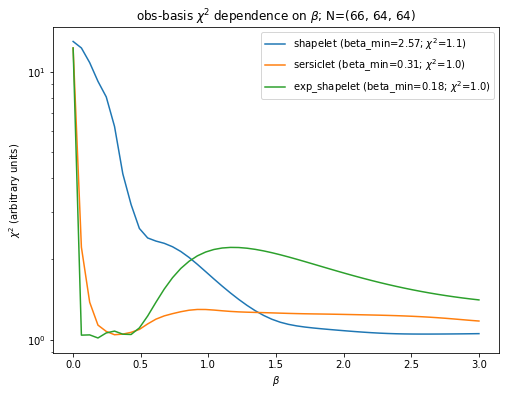

In [10]:
data = datacube.stack()
Npix = data.shape[0]*data.shape[1]
sky = np.std(data[:16,:16])

# make dummy sample
theta = np.random.rand(len(sampled_pars))

bmin, bmax = 0.001, 3
Nb = 50
betas = np.linspace(bmin, bmax, Nb)

pars_shapelet_b = deepcopy(pars_shapelet)
pars_sersiclet_b = deepcopy(pars_sersiclet)
pars_exp_shapelet_b = deepcopy(pars_exp_shapelet)

chi2_shapelet = np.zeros(Nb)
chi2_sersiclet = np.zeros(Nb)
chi2_exp_shapelet = np.zeros(Nb)

for i, beta in enumerate(betas):
    if (i%10==0):
        print(f'{i} of {Nb}')
        
    pars_shapelet_b['intensity']['basis_kwargs']['beta'] = beta
    pars_sersiclet_b['intensity']['basis_kwargs']['beta'] = beta
    pars_exp_shapelet_b['intensity']['basis_kwargs']['beta'] = beta
            
    shapelet, mle_shapelet, imap_shapelet = make_basis_imap(theta, datacube, pars_shapelet_b)
    sersiclet, mle_sersiclet, imap_sersiclet = make_basis_imap(theta, datacube, pars_sersiclet_b)
    exp_shapelet, mle_exp_shapelet, imap_exp_shapelet = make_basis_imap(theta, datacube, pars_exp_shapelet_b)
    
    chi2_shapelet[i] = np.sum((shapelet-data)**2/sky**2) / Npix
    chi2_sersiclet[i] = np.sum((sersiclet-data)**2/sky**2) / Npix
    chi2_exp_shapelet[i] = np.sum((exp_shapelet-data)**2/sky**2) / Npix
    
shapelet_min = betas[np.argmin(chi2_shapelet)]
sersiclet_min = betas[np.argmin(chi2_sersiclet)]
exp_shapelet_min = betas[np.argmin(chi2_exp_shapelet)]

shapelet_min_chi2 = np.min(chi2_shapelet)
sersiclet_min_chi2 = np.min(chi2_sersiclet)
exp_shapelet_min_chi2 = np.min(chi2_exp_shapelet)
    
plt.plot(betas, chi2_shapelet,
         label=f'shapelet (beta_min={shapelet_min:.2f}; $\chi^2$={shapelet_min_chi2:.1f})')
plt.plot(betas, chi2_sersiclet,
         label=f'sersiclet (beta_min={sersiclet_min:.2f}; $\chi^2$={sersiclet_min_chi2:.1f})')
plt.plot(betas, chi2_exp_shapelet,
         label=f'exp_shapelet (beta_min={exp_shapelet_min:.2f}; $\chi^2$={exp_shapelet_min_chi2:.1f})')
plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\chi^2$ (arbitrary units)')      
plt.yscale('log')
plt.axhline(0, lw=2, c='k')

nfuncs = (len(mle_shapelet), len(mle_sersiclet), len(mle_exp_shapelet))
plt.title(rf'{plane}-basis $\chi^2$ dependence on $\beta$; N={nfuncs}')

plt.gcf().patch.set_facecolor('w')
plt.gcf().set_size_inches(8,6)

min shapelet beta: 2.5715714285714286
min sersiclet beta: 0.3070204081632653
min exp_shapelet beta: 0.1846122448979592


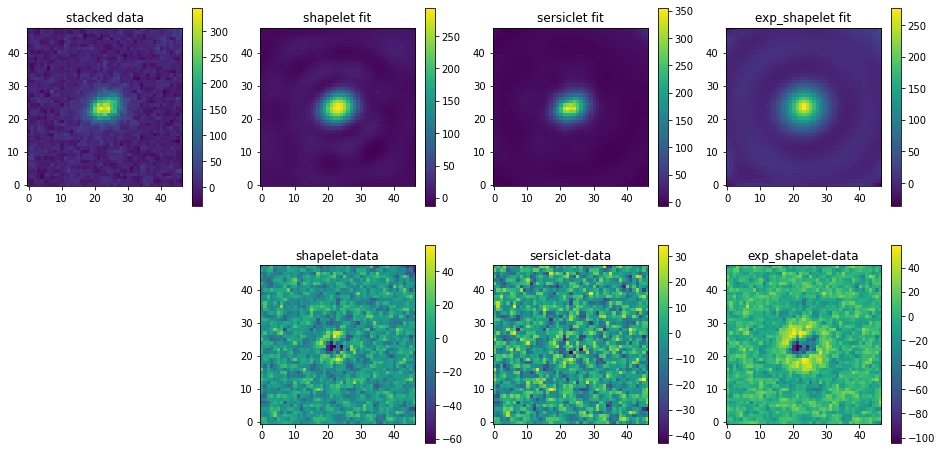

In [11]:
pars_shapelet['beta'] = shapelet_min
pars_sersiclet['beta'] = sersiclet_min
pars_exp_shapelet['beta'] = exp_shapelet_min

print(f'min shapelet beta: {shapelet_min}')
print(f'min sersiclet beta: {sersiclet_min}')
print(f'min exp_shapelet beta: {exp_shapelet_min}')

shapelet, mle_shapelet, imap_shapelet = make_basis_imap(theta, datacube, pars_shapelet)
sersiclet, mle_sersiclet, imap_sersiclet = make_basis_imap(theta, datacube, pars_sersiclet)
exp_shapelet, mle_exp_shapelet, imap_exp_shapelet = make_basis_imap(theta, datacube, pars_exp_shapelet)

plt.subplot(241)
plt.imshow(data, origin='lower')
plt.colorbar()
plt.title('stacked data')

plt.subplot(242)
plt.imshow(shapelet, origin='lower')
plt.colorbar()
plt.title('shapelet fit')

plt.subplot(243)
plt.imshow(sersiclet, origin='lower')
plt.colorbar()
plt.title('sersiclet fit')

plt.subplot(244)
plt.imshow(exp_shapelet, origin='lower')
plt.colorbar()
plt.title('exp_shapelet fit')

plt.subplot(246)
plt.imshow(shapelet-data, origin='lower')
plt.colorbar()
plt.title('shapelet-data')

plt.subplot(247)
plt.imshow(sersiclet-data, origin='lower')
plt.colorbar()
plt.title('sersiclet-data')

plt.subplot(248)
plt.imshow(exp_shapelet-data, origin='lower')
plt.colorbar()
plt.title('exp_shapelet-data')

plt.gcf().set_size_inches(16,8)

In [12]:
Npix = data.shape[0]*data.shape[1]
sky = np.std(data[:16,:16])
np.sum((exp_shapelet-data)**2/sky**2) / Npix

1.9726882388317504